#**Previsão do filme vencedor do Oscar de Melhor Filme**

In [250]:
!pip install -q fuzzywuzzy
!pip install -q lime

In [251]:
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import seaborn as sns
from fuzzywuzzy import process
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  confusion_matrix

In [252]:
warnings.filterwarnings("ignore")
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

##Preparação da base

In [144]:
oscar = pd.read_csv("/content/drive/MyDrive/the_oscar_award.csv")
gg = pd.read_csv("/content/drive/MyDrive/golden_globe_awards.csv")
tmdb = pd.read_csv("/content/drive/MyDrive/TMDB_movie_dataset_v11.csv", on_bad_lines='skip')
imdb = pd.read_csv('/content/drive/MyDrive/title.ratings.tsv.gz', compression='gzip', delimiter='\t')

In [145]:
oscar['film'] = oscar['film'].str.strip().str.lower()
tmdb['title'] = tmdb['title'].str.strip().str.lower()
gg['nominee'] = gg['nominee'].str.strip().str.lower()

###IMDb

In [146]:
imdb.columns = ['imdb_id', 'imdb_rating', 'imdb_popularity']
imdb.head()

,imdb_id,imdb_rating,imdb_popularity
0,tt0000001,5.7,2096
1,tt0000002,5.6,282
2,tt0000003,6.5,2114
3,tt0000004,5.4,182
4,tt0000005,6.2,2844


###Oscar

In [147]:
oscar

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,the noose,False
1,1927,1928,1,ACTOR,Emil Jannings,the last command,True
2,1927,1928,1,ACTRESS,Louise Dresser,a ship comes in,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,sadie thompson,False
...,...,...,...,...,...,...,...
10884,2023,2024,96,WRITING (Original Screenplay),Written by Celine Song,past lives,False
10885,2023,2024,96,JEAN HERSHOLT HUMANITARIAN AWARD,NaN,NaN,True
10886,2023,2024,96,HONORARY AWARD,"To Angela Bassett, who has inspired audiences ...",NaN,True
10887,2023,2024,96,HONORARY AWARD,"To Mel Brooks, for his comedic brilliance, pro...",NaN,True


In [148]:
main_cat = oscar['category'][oscar['category'].str.contains('actor|actress|screenplay|directing|writing|acting', case=False, regex=True)].unique()

oscar['main_cat_nomination'] = oscar['category'].isin(main_cat)

In [149]:
oscar['main_nominations'] = oscar.groupby('film')['main_cat_nomination'].transform('sum')

oscar['main_nominations'] = oscar['main_nominations'].fillna(0).astype(int)
oscar.drop(columns = 'main_cat_nomination', inplace = True)

oscar

,year_film,year_ceremony,ceremony,category,name,film,winner,main_nominations
0,1927,1928,1,ACTOR,Richard Barthelmess,the noose,False,1
1,1927,1928,1,ACTOR,Emil Jannings,the last command,True,2
2,1927,1928,1,ACTRESS,Louise Dresser,a ship comes in,False,1
3,1927,1928,1,ACTRESS,Janet Gaynor,7th heaven,True,3
4,1927,1928,1,ACTRESS,Gloria Swanson,sadie thompson,False,1
...,...,...,...,...,...,...,...,...
10884,2023,2024,96,WRITING (Original Screenplay),Written by Celine Song,past lives,False,1
10885,2023,2024,96,JEAN HERSHOLT HUMANITARIAN AWARD,NaN,NaN,True,0
10886,2023,2024,96,HONORARY AWARD,"To Angela Bassett, who has inspired audiences ...",NaN,True,0
10887,2023,2024,96,HONORARY AWARD,"To Mel Brooks, for his comedic brilliance, pro...",NaN,True,0


In [150]:
melhor_filme_variacoes = ['BEST PICTURE', 'OUTSTANDING PICTURE', 'BEST MOTION PICTURE', 'OUTSTANDING MOTION PICTURE', 'OUTSTANDING PRODUCTION']
oscar_bp = oscar[oscar['category'].isin(melhor_filme_variacoes)]
oscar_bp['other_year'] = oscar_bp['year_film'] - 1

In [151]:
oscar_bp['other_year'][2028] = 1944
oscar_bp['film'][8194] = 'moulin rouge!'

In [152]:
indicacoes_por_filme = (oscar.groupby(['film', 'year_ceremony']).size().reset_index(name='nominations'))
vitorias_por_filme = (oscar[(oscar['winner'] == True) & (~oscar['category'].isin(melhor_filme_variacoes))].groupby(['film', 'year_ceremony']).size().reset_index(name='wins'))

oscar_bp = oscar_bp.merge(indicacoes_por_filme, on=['film', 'year_ceremony'], how='left').merge(vitorias_por_filme, on=['film', 'year_ceremony'], how='left')
oscar_bp[['nominations', 'wins']] = oscar_bp[['nominations', 'wins']].fillna(0).astype(int)

oscar_bp

,year_film,year_ceremony,ceremony,category,name,film,winner,main_nominations,other_year,nominations,wins
0,1927,1928,1,OUTSTANDING PICTURE,The Caddo Company,the racket,False,0,1926,1,0
1,1927,1928,1,OUTSTANDING PICTURE,Fox,7th heaven,False,3,1926,5,3
2,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,wings,True,0,1926,2,1
3,1928,1929,2,OUTSTANDING PICTURE,Feature Productions,alibi,False,1,1927,2,0
4,1928,1929,2,OUTSTANDING PICTURE,Fox,in old arizona,False,2,1927,4,1
...,...,...,...,...,...,...,...,...,...,...,...
596,2023,2024,96,BEST PICTURE,"Bradley Cooper, Steven Spielberg, Fred Berner,...",maestro,False,3,2022,7,0
597,2023,2024,96,BEST PICTURE,"Emma Thomas, Charles Roven and Christopher Nol...",oppenheimer,True,5,2022,13,6
598,2023,2024,96,BEST PICTURE,"David Hinojosa, Christine Vachon and Pamela Ko...",past lives,False,1,2022,2,0
599,2023,2024,96,BEST PICTURE,"Ed Guiney, Andrew Lowe, Yorgos Lanthimos and E...",poor things,False,4,2022,11,4


###Golden Globe

In [153]:
gg = gg[(gg['category'] == 'Picture') |
        (gg['category'] == 'Best Motion Picture - Drama') |
        (gg['category'] == 'Best Motion Picture - Musical or Comedy') |
        (gg['category'] == 'Picture - Musical') |
        (gg['category'] == 'Picture - Drama')]

gg['film'] = gg['nominee']

gg.drop('nominee', axis = 1, inplace = True)

gg

,year_film,year_award,ceremony,category,film,win
3,1943,1944,1,Picture,the song of bernadette,True
9,1944,1945,2,Picture,going my way,True
16,1945,1946,3,Picture,the lost weekend,True
24,1946,1947,4,Picture,the best years of our lives,True
35,1947,1948,5,Picture,gentleman's agreement,True
...,...,...,...,...,...,...
7869,2019,2020,77,Best Motion Picture - Musical or Comedy,once upon a time...in hollywood,True
7870,2019,2020,77,Best Motion Picture - Musical or Comedy,dolemite is my name,False
7871,2019,2020,77,Best Motion Picture - Musical or Comedy,jojo rabbit,False
7872,2019,2020,77,Best Motion Picture - Musical or Comedy,knives out,False


In [154]:
oscar_bp['nomination_gg'] = oscar_bp.apply(
    lambda row: any((gg['film'] == row['film']) & (gg['year_film'] == row['year_film'])),
    axis=1
)

oscar_bp['winner_gg'] = oscar_bp.apply(
    lambda row: any((gg['film'] == row['film']) & (gg['year_film'] == row['year_film']) & (gg['win'] == True)),
    axis=1
)

In [155]:
indicados = [filme.strip().lower() for filme in ['Nomadland', 'The Father', 'Mank', 'Promising Young Woman', 'The Trial of the Chicago 7', 'The Power of the Dog', 'CODA', 'Belfast', 'Dune', 'King Richard', 'The Fabelmans', 'Avatar: The Way of Water', 'Elvis', 'Tár', 'Top Gun: Maverick', 'Oppenheimer', 'Killers of the Flower Moon', 'Anatomy of a fall', 'The Zone of Interest', 'Past Lives', 'Maestro', 'West Side Story', 'Cyrano', "Don't Look Up", 'Licorice Pizza', 'Tick, Tick... Boom!', 'The Banshees of Inisherin', 'Babylon', 'Everything Everywhere All at Once', 'Glass Onion: A Knives Out Mystery', 'Triangle of Sadness', 'Poor Things', 'Air', 'Barbie', 'The Holdovers', 'May December', 'American Fiction']]
vencedores = [filme.strip().lower() for filme in ['Nomadland', 'The Power of the Dog', 'The Fabelmans', 'Oppenheimer', 'Poor Things', 'The Banshees of Inisherin', 'West Side Story']]

oscar_bp.loc[oscar_bp['film'].isin(indicados), 'nomination_gg'] = True
oscar_bp.loc[oscar_bp['film'].isin(vencedores), 'winner_gg'] = True

In [156]:
oscar_bp

,year_film,year_ceremony,ceremony,category,name,film,winner,main_nominations,other_year,nominations,wins,nomination_gg,winner_gg
0,1927,1928,1,OUTSTANDING PICTURE,The Caddo Company,the racket,False,0,1926,1,0,False,False
1,1927,1928,1,OUTSTANDING PICTURE,Fox,7th heaven,False,3,1926,5,3,False,False
2,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,wings,True,0,1926,2,1,False,False
3,1928,1929,2,OUTSTANDING PICTURE,Feature Productions,alibi,False,1,1927,2,0,False,False
4,1928,1929,2,OUTSTANDING PICTURE,Fox,in old arizona,False,2,1927,4,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,2023,2024,96,BEST PICTURE,"Bradley Cooper, Steven Spielberg, Fred Berner,...",maestro,False,3,2022,7,0,True,False
597,2023,2024,96,BEST PICTURE,"Emma Thomas, Charles Roven and Christopher Nol...",oppenheimer,True,5,2022,13,6,True,True
598,2023,2024,96,BEST PICTURE,"David Hinojosa, Christine Vachon and Pamela Ko...",past lives,False,1,2022,2,0,True,False
599,2023,2024,96,BEST PICTURE,"Ed Guiney, Andrew Lowe, Yorgos Lanthimos and E...",poor things,False,4,2022,11,4,True,True


###TMDB

In [157]:
tmdb = pd.merge(imdb, tmdb, how='inner', left_on='imdb_id', right_on='imdb_id')
tmdb = tmdb[tmdb['release_date'].notna()]
tmdb['year'] = tmdb['release_date'].str[:4].astype(int)
tmdb

,imdb_id,imdb_rating,imdb_popularity,id,title,vote_average,vote_count,status,release_date,revenue,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,year
0,tt0000001,5.7,2096,16612,carmencita,5.200,64,Released,1894-03-14,0,...,The first woman to appear in front of an Ediso...,3.092,/sDbM3NnfnsEZYEJMt4O06Vb8Z9k.jpg,NaN,Documentary,Edison Studios,United States of America,No Language,"dancer, silent film",1894
1,tt0000002,5.6,282,16613,clown and his dogs,4.700,10,Released,1892-10-28,0,...,Short film of 300 individually painted images.,2.072,/4ACC8V9ZSZ9AlWcAqUeF8aMcZV6.jpg,NaN,Animation,NaN,France,No Language,"clown, dog, silent film, 19th century, circus ...",1892
2,tt0000003,6.5,2114,88013,poor pierrot,6.029,86,Released,1892-10-28,0,...,"One night, Arlequin comes to see his lover Col...",3.684,/1e2ytD2cSxAz1r0SItxDmZUPb4i.jpg,NaN,"Comedy, Animation",NaN,France,French,"19th century, short film, pierrot, arlequin, t...",1892
3,tt0000004,5.4,182,16622,a good beer,4.000,8,Released,1892-10-28,0,...,NaN,1.168,/osv0TcCymlsOucqkZBssSuS4tD.jpg,NaN,Animation,NaN,France,No Language,"19th century, short film, théâtre optique, les...",1892
4,tt0000005,6.2,2844,16624,blacksmith scene,5.511,87,Released,1893-05-08,0,...,Three men hammer on an anvil and pass a bottle...,3.675,/c76bs0S90EFhB5ww3i6DlYQTVk.jpg,NaN,"Drama, Documentary",Edison Studios,United States of America,No Language,"blacksmith, beer, workmen",1893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431416,tt9916428,3.6,19,622812,the secret of china,7.000,1,Released,2019-08-08,0,...,NaN,1.564,/waQF2ekDdw9Cd6RzCQXPbmNoqMu.jpg,NaN,"History, War",Emei Film Studio,China,Mandarin,NaN,2019
431417,tt9916460,8.9,19,638638,pink taxi,0.000,0,Released,2019-09-19,0,...,One day Apostolis decides that he wants to be ...,0.600,/zom5FHTqJjutluw4wHDsNxzCm8K.jpg,NaN,Comedy,"Film Lemon, Film School of the Aristotle Unive...",Greece,Greek,NaN,2019
431418,tt9916538,8.3,9,586983,kuambil lagi hatiku,0.000,0,Released,2019-03-21,0,...,"Agra City, India, will be the witness to the m...",0.850,/hDmFxzU4v2wkTrRHzV9x7lrihJc.jpg,NaN,Drama,"Perusahaan Film Negara, Taman Wisata Candi",Indonesia,Indonesian,NaN,2019
431419,tt9916544,6.8,73,633271,my sweet prince,5.800,4,Released,2019-03-12,0,...,"Alcopops, VHS tapes, cigarettes, boys, MSN Mes...",1.026,/udjg6niHPf6yH8IIpht5baM9wER.jpg,NaN,Drama,"Hello Mozart, Plimsoll Productions",United Kingdom,English,"coming of age, gay interest, lgbt, lgbt teen, ...",2019


In [158]:
tmdb.columns

Index(['imdb_id', 'imdb_rating', 'imdb_popularity', 'id', 'title',
       'vote_average', 'vote_count', 'status', 'release_date', 'revenue',
       'runtime', 'adult', 'backdrop_path', 'budget', 'homepage',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'tagline', 'genres', 'production_companies',
       'production_countries', 'spoken_languages', 'keywords', 'year'],
      dtype='object')

In [159]:
df1 = pd.merge(oscar_bp, tmdb, left_on = ['year_film', 'film'], right_on = ['year', 'title'])
df2 = pd.merge(oscar_bp, tmdb, left_on = ['year_ceremony', 'film'], right_on = ['year', 'title'])
df3 = pd.merge(oscar_bp, tmdb, left_on = ['other_year', 'film'], right_on = ['year', 'title'])

df = pd.concat([df1, df2, df3]).drop_duplicates()

In [160]:
df = df.sort_values('popularity', ascending=False).drop_duplicates(subset='film')
df = df.sort_values(by='year_film').reset_index(drop=True)

df

,year_film,year_ceremony,ceremony,category,name,film,winner,main_nominations,other_year,nominations,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,year
0,1927,1928,1,OUTSTANDING PICTURE,Fox,7th heaven,False,3,1926,5,...,A dejected Parisian sewer worker feels his pra...,6.652,/3ETXMu5PrcVMRJpfN2Z3MwcfXzy.jpg,NaN,"Drama, Romance",Fox Film Corporation,United States of America,No Language,"optimism, based on play or musical, love, blac...",1927
1,1927,1928,1,OUTSTANDING PICTURE,Paramount Famous Lasky,wings,True,0,1926,2,...,"Two young men, one rich, one middle class, bot...",10.817,/kEl6KCBgdmT1Nex3ka0EIWAOmtm.jpg,"Youth, hitting the clouds! Laughing at danger!...","Drama, Action, War, Romance",Paramount Famous Lasky Corporation,United States of America,No Language,"friendship, paris, france, love triangle, worl...",1927
2,1927,1928,1,OUTSTANDING PICTURE,The Caddo Company,the racket,False,0,1926,1,...,A renegade police captain sets out to catch a ...,2.849,/wHAJfHslSb6OpNQmj1hu9aE9IQR.jpg,NaN,"Crime, Drama","The Caddo Company, Paramount",United States of America,No Language,"bootlegger, reporter, silent film",1928
3,1928,1929,2,OUTSTANDING PICTURE,Metro-Goldwyn-Mayer,the broadway melody,True,2,1927,3,...,The vaudeville act of Harriet and Queenie Maho...,6.957,/giq8GJs8YGMzHxeKxNSuwzAdd1c.jpg,All talking. All singing. All dancing.,"Music, Romance, Drama",Metro-Goldwyn-Mayer,United States of America,English,"new york city, dancing, love triangle, revue g...",1929
4,1928,1929,2,OUTSTANDING PICTURE,Fox,in old arizona,False,2,1927,4,...,Army Sergeant Mickey Dunn sets out in pursuit ...,5.197,/x1XSQeLUdoi72P5UOXqAyL46B9a.jpg,The first all-talking sound-on-film feature.,"Action, Western",Fox Film Corporation,United States of America,"English, Italian, Spanish","arizona, outlaw, bandit, 19th century",1928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,2023,2024,96,BEST PICTURE,"Ben LeClair, Nikos Karamigios, Cord Jefferson ...",american fiction,False,3,2022,5,...,Thelonious “Monk” Ellison's writing career has...,6.826,/gdtxPfdqn3YYcvd7kdG3CLJBHFe.jpg,NaN,"Comedy, Drama","Orion Pictures, T-Street Productions, MRC, 3 A...",United States of America,English,"sibling relationship, boston, massachusetts, w...",2023
575,2023,2024,96,BEST PICTURE,"James Wilson, Producer",the zone of interest,False,2,2022,5,...,"The commandant of Auschwitz, Rudolf Höss, and ...",8.032,/zYgopRlHlZdizDFjXb0I5T6iEPY.jpg,NaN,"Drama, War","A24, Extreme Emotions, Film4 Productions, Hous...","Poland, United Kingdom, United States of America","English, German, Polish","husband wife relationship, based on novel or b...",2023
576,2023,2024,96,BEST PICTURE,"Bradley Cooper, Steven Spielberg, Fred Berner,...",maestro,False,3,2022,7,...,A portrait of Leonard Bernstein's singular cha...,8.391,/qiUHDS4THyB0yUByvidtaNP30sT.jpg,NaN,"Drama, Music","Amblin Entertainment, Fred Berner Films, Joint...",United States of America,English,"husband wife relationship, conductor, marriage...",2023
577,2023,2024,96,BEST PICTURE,"Ed Guiney, Andrew Lowe, Yorgos Lanthimos and E...",poor things,False,4,2022,11,...,Bella Baxter is brought back to life by the br...,27.804,/IFQXRyH6EP3DCqEIMKuYnohaEo.jpg,She's like nothing you've ever seen.,"Science Fiction, Romance, Comedy","Element Pictures, Film4 Productions, Searchlig...","Ireland, United Kingdom, United States of America",English,"ship, london, england, experiment, paris, fran...",2023


In [161]:
missing = oscar_bp[~oscar_bp['film'].isin(df['film'])]

missing_titles = missing[['film', 'year_film']].to_records(index=False)

tmdb_titles = tmdb['title'].tolist()

tmdb_records = tmdb[['title', 'year']].to_records(index=False)

matched_titles = {}

for missing_film, missing_year in missing_titles:
    relevant_tmdb = [(title, year) for title, year in tmdb_records if year >= missing_year - 1 and year <= missing_year + 1]

    matches = process.extract(missing_film, [title for title, _ in relevant_tmdb], limit=3)

    matched_titles[missing_film] = [(match[0], relevant_tmdb[i][1]) for i, match in enumerate(matches) if match[0] in [title for title, _ in relevant_tmdb]]

for original, matches in matched_titles.items():
    print(f"Filme faltante: {original}")
    for match in matches:
        print(f"  Possível correspondência: {match[0]} do ano {match[1]}")

Filme faltante: hollywood revue
  Possível correspondência: the hollywood revue of 1929 do ano 1927
  Possível correspondência: life in hollywood no. 4 do ano 1929
  Possível correspondência: the song writers' revue do ano 1927
Filme faltante: the patriot
  Possível correspondência: the gypsy charmer do ano 1927
  Possível correspondência: the pleasure garden do ano 1929
  Possível correspondência: the mountain bandit do ano 1927
Filme faltante: les miserables
  Possível correspondência: les misérables do ano 1936
  Possível correspondência: les misérables do ano 1935
  Possível correspondência: les affaires publiques do ano 1934
Filme faltante: the invaders
  Possível correspondência: the tale of the fox do ano 1942
  Possível correspondência: the lady from lisbon do ano 1941
  Possível correspondência: the marriage of mara szüts do ano 1942
Filme faltante: sunset blvd.
  Possível correspondência: sunset in the west do ano 1950
  Possível correspondência: sunset boulevard do ano 1951


In [162]:
primeiros_matches = []

for original, matches in matched_titles.items():
    if matches:
        primeiro_match = matches[0][0]
        primeiros_matches.append(primeiro_match)

for index, sel in zip(missing.index, primeiros_matches):
    oscar_bp.at[index, 'film'] = sel

In [163]:
oscar_bp['film'][1392] = '49th parallel'
oscar_bp['film'][2473] = 'sunset boulevard'

###DataFrame final

In [164]:
df1 = pd.merge(oscar_bp, tmdb, left_on = ['year_film', 'film'], right_on = ['year', 'title'])
df2 = pd.merge(oscar_bp, tmdb, left_on = ['year_ceremony', 'film'], right_on = ['year', 'title'])
df3 = pd.merge(oscar_bp, tmdb, left_on = ['other_year', 'film'], right_on = ['year', 'title'])

df = pd.concat([df1, df2, df3]).drop_duplicates()

In [165]:
df = df.sort_values('popularity', ascending=False).drop_duplicates(subset=['film', 'year_film'])
df = df.sort_values(by='year_film').reset_index(drop=True)

In [166]:
df['release_month'] = df['release_date'].str[5:7].astype(int)
df.drop(columns = ['release_date', 'ceremony', 'category', 'name', 'other_year', 'year_film', 'id', 'title', 'status', 'adult', 'backdrop_path', 'homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'tagline', 'year', 'production_companies', 'spoken_languages', 'production_countries'], inplace = True)

df.columns

Index(['year_ceremony', 'film', 'winner', 'main_nominations', 'nominations',
       'wins', 'nomination_gg', 'winner_gg', 'imdb_rating', 'imdb_popularity',
       'vote_average', 'vote_count', 'revenue', 'runtime', 'budget',
       'original_language', 'popularity', 'genres', 'keywords',
       'release_month'],
      dtype='object')

In [167]:
df['profit'] = df['revenue'] - 2*df['budget']
df['proportional'] = df['profit'] / df['budget']

In [168]:
warnings.filterwarnings("ignore")
#kotfm
df['budget'][591] = 200000000
df['revenue'][591] = 156922344
df['vote_count'][591] = 3206
df['vote_average'][591] = 7.537
#maestro
df['budget'][592] = 80000000
df['revenue'][592] = 300000
df['vote_count'][592] = 688
df['vote_average'][592] = 6.4
#the zone of interest
df['budget'][593] = 15000000
df['revenue'][593] = 48975567
df['vote_count'][593] = 1631
df['vote_average'][593] = 7.1
#american fiction
df['budget'][594] = 16000000
df['revenue'][594] = 22483370
df['vote_count'][594] = 952
df['vote_average'][594] = 7.1
#the holdovers
df['budget'][595] = 13000000
df['revenue'][595] = 42513270
df['vote_count'][595] = 1479
df['vote_average'][595] = 7.7
#past lives
df['budget'][596] = 12000000
df['revenue'][596] = 28126646
df['vote_count'][596] = 1587
df['vote_average'][596] = 7.839
#poor things
df['budget'][597] = 35000000
df['revenue'][597] = 117607117
df['vote_count'][597] = 4021
df['vote_average'][597] = 7.829
#oppenheimer
df['budget'][598] = 100000000
df['revenue'][598] = 952000000
df['vote_count'][598] = 9084
df['vote_average'][598] = 8.140
#anatomia de uma queda
df['budget'][599] = 6700000
df['revenue'][599] = 35634133
df['vote_count'][599] = 2352
df['vote_average'][599] = 7.6
#barbie
df['budget'][600] = 145000000
df['revenue'][600] = 1445638421
df['vote_count'][600] = 8991
df['vote_average'][600] = 7.0

In [169]:
df_nogenre = df.copy()

In [170]:
unique_genres = set()
df['genres'].str.split(',').apply(unique_genres.update)
unique_genres = list(unique_genres)

for genre in unique_genres:
    genre = genre.strip()
    df[genre] = df['genres'].str.contains(genre, case=False, regex=False).astype(int)

In [171]:
df

,year_ceremony,film,winner,main_nominations,nominations,wins,nomination_gg,winner_gg,imdb_rating,imdb_popularity,...,Mystery,Drama,Romance,Action,History,Thriller,Animation,Family,Science Fiction,Adventure
0,1928,wings,True,0,2,1,False,False,7.5,14922,...,0,1,1,1,0,0,0,0,0,0
1,1928,7th heaven,False,3,5,3,False,False,7.6,4274,...,0,1,1,0,0,0,0,0,0,0
2,1928,the racket,False,0,1,0,False,False,6.6,1640,...,0,1,0,0,0,0,0,0,0,0
3,1929,the gypsy charmer,False,3,5,1,False,False,6.5,81,...,0,1,1,0,0,0,0,0,0,0
4,1929,the broadway melody,True,2,3,0,False,False,5.6,8207,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,2024,maestro,False,3,7,0,True,False,6.5,64745,...,0,1,0,0,0,0,0,0,0,0
597,2024,anatomy of a fall,False,3,5,1,True,False,7.7,155005,...,1,1,0,0,0,0,0,0,0,0
598,2024,the zone of interest,False,2,5,2,True,False,7.4,115559,...,0,1,0,0,0,0,0,0,0,0
599,2024,the holdovers,False,3,5,1,True,False,7.9,169328,...,0,1,0,0,0,0,0,0,0,0


In [172]:
winners = df[df['winner'] == True].drop(columns = 'winner')

winners

,year_ceremony,film,main_nominations,nominations,wins,nomination_gg,winner_gg,imdb_rating,imdb_popularity,vote_average,...,Mystery,Drama,Romance,Action,History,Thriller,Animation,Family,Science Fiction,Adventure
0,1928,wings,0,2,1,False,False,7.5,14922,7.205,...,0,1,1,1,0,0,0,0,0,0
4,1929,the broadway melody,2,3,0,False,False,5.6,8207,5.193,...,0,1,1,0,0,0,0,0,0,0
11,1930,all quiet on the western front,3,4,1,False,False,8.1,68729,7.756,...,0,1,0,0,0,0,0,0,0,0
16,1931,cimarron,4,7,2,False,False,5.8,7077,5.500,...,0,1,0,0,1,0,0,0,0,0
22,1932,grand hotel,0,1,0,False,False,7.3,21209,6.948,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2020,parasite,2,6,3,False,False,8.5,1003715,8.515,...,0,1,0,0,0,1,0,0,0,0
569,2021,nomadland,3,6,2,True,True,7.3,188025,7.237,...,0,1,0,0,0,0,0,0,0,0
578,2022,coda,2,3,2,True,False,8.0,171181,7.967,...,0,1,1,0,0,0,0,0,0,0
588,2023,everything everywhere all at once,6,11,6,True,False,7.8,556067,7.822,...,0,0,0,1,0,0,0,0,1,1


##Exploração dos dados

In [341]:
minmax = MinMaxScaler()

### Todos os filmes

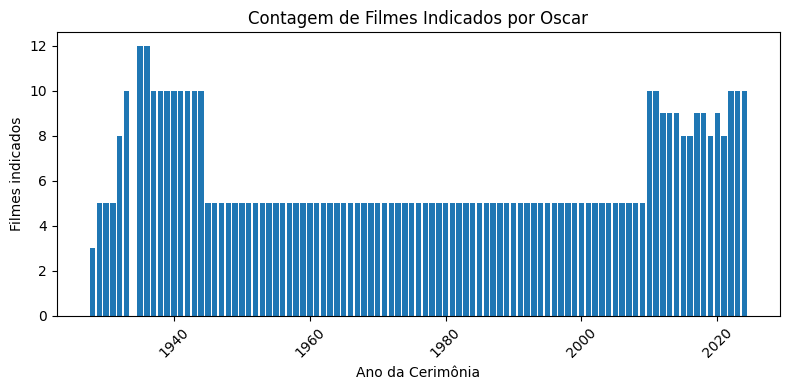

In [342]:
plt.figure(figsize=(8, 4))
a = df['year_ceremony'].value_counts().sort_index()
plt.bar(x = a.index, height = a.values)

plt.xlabel('Ano da Cerimônia')
plt.ylabel('Filmes indicados')
plt.title('Contagem de Filmes Indicados por Oscar')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

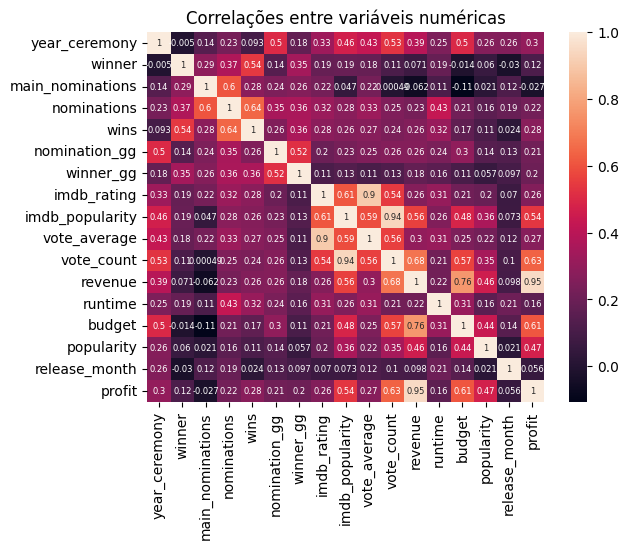

In [343]:
numeric_variables = df_nogenre.drop(columns = ['film', 'original_language', 'genres', 'keywords', 'proportional'])

sns.heatmap(numeric_variables.corr(), annot = True, annot_kws = {"size": 6})

plt.title('Correlações entre variáveis numéricas')
plt.show()

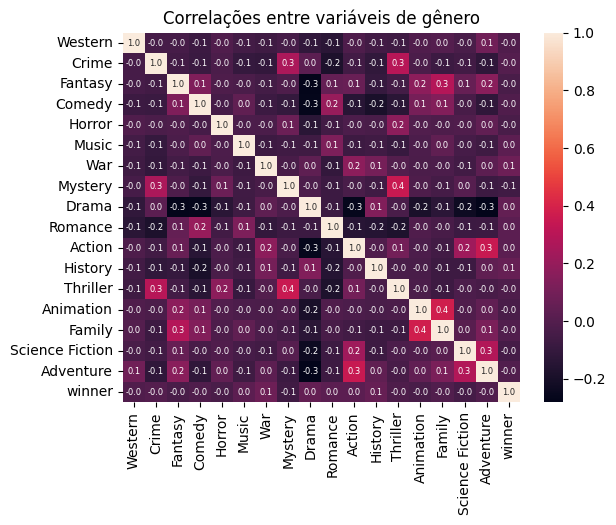

In [344]:
genre_variables = df.drop(columns = df_nogenre.columns)
genre_variables['winner'] = df['winner']

sns.heatmap(genre_variables.corr(), annot = True, fmt='.1f', annot_kws = {"size": 6})

plt.title('Correlações entre variáveis de gênero')
plt.show()

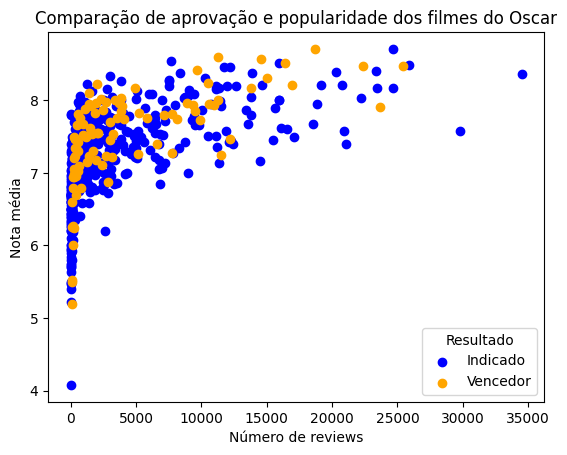

In [345]:
df_indicado = df[df['winner'] == False]
df_vencedor = df[df['winner'] == True]

plt.scatter(
    x=df_indicado['vote_count'],
    y=df_indicado['vote_average'],
    c='blue',
    label='Indicado'
)

plt.scatter(
    x=df_vencedor['vote_count'],
    y=df_vencedor['vote_average'],
    c='orange',
    label='Vencedor'
)

plt.xlabel('Número de reviews')
plt.ylabel('Nota média')
plt.title('Comparação de aprovação e popularidade dos filmes do Oscar')

plt.legend(title='Resultado')
plt.show()

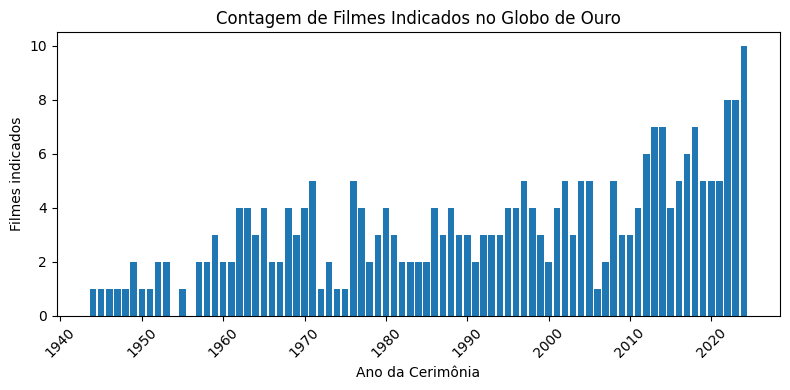

In [346]:
df_gg = df[df['nomination_gg'] == True]

a = df_gg['year_ceremony'].value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.bar(x = a.index, height = a.values)

plt.xlabel('Ano da Cerimônia')
plt.ylabel('Filmes indicados')
plt.title('Contagem de Filmes Indicados no Globo de Ouro')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

###Média dos filmes

In [347]:
num_columns = numeric_variables.columns
minmax_variables = pd.DataFrame(minmax.fit_transform(numeric_variables), columns = num_columns)

nao_vencedores_mm = minmax_variables[minmax_variables['winner'] == False].groupby('year_ceremony').mean().reset_index()
vencedores_mm = minmax_variables[minmax_variables['winner'] == True].set_index('year_ceremony')

comparacao_mm = pd.merge(nao_vencedores_mm, vencedores_mm, on='year_ceremony', suffixes=('_nao_vencedor', '_vencedor'))

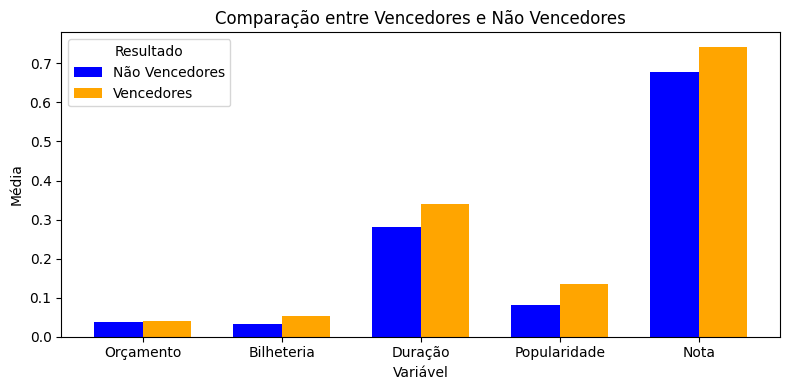

In [348]:
variaveis = ['Orçamento', 'Bilheteria', 'Duração', 'Popularidade', 'Nota']
nao_vencedor = [
    comparacao_mm.mean()['budget_nao_vencedor'],
    comparacao_mm.mean()['revenue_nao_vencedor'],
    comparacao_mm.mean()['runtime_nao_vencedor'],
    comparacao_mm.mean()['vote_count_nao_vencedor'],
    comparacao_mm.mean()['vote_average_nao_vencedor']
]
vencedor = [
    comparacao_mm.mean()['budget_vencedor'],
    comparacao_mm.mean()['revenue_vencedor'],
    comparacao_mm.mean()['runtime_vencedor'],
    comparacao_mm.mean()['vote_count_vencedor'],
    comparacao_mm.mean()['vote_average_vencedor']
]

x = np.arange(len(variaveis))
largura = 0.35

fig, ax = plt.subplots(figsize=(8, 4))

barras_nao_vencedor = ax.bar(x - largura/2, nao_vencedor, largura, label='Não Vencedores', color='blue')
barras_vencedor = ax.bar(x + largura/2, vencedor, largura, label='Vencedores', color='orange')

ax.set_xlabel('Variável')
ax.set_ylabel('Média')
ax.set_title('Comparação entre Vencedores e Não Vencedores')
ax.set_xticks(x)
ax.set_xticklabels(variaveis)
ax.legend(title='Resultado')

plt.tight_layout()
plt.show()

In [349]:
nao_vencedores = numeric_variables[numeric_variables['winner'] == False].groupby('year_ceremony').mean().reset_index()

vencedores = numeric_variables[numeric_variables['winner'] == True].set_index('year_ceremony')

comparacao = pd.merge(nao_vencedores, vencedores, on='year_ceremony', suffixes=('_nao_vencedor', '_vencedor'))

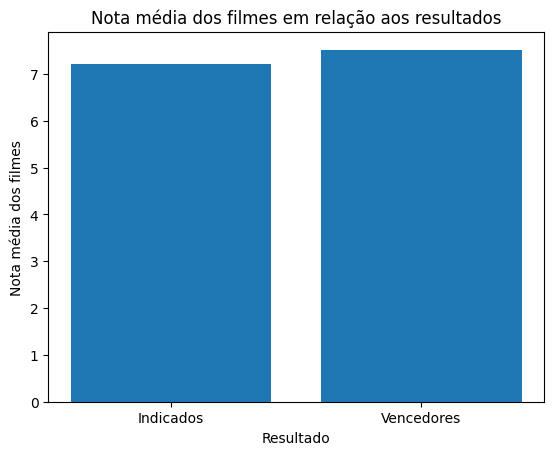

In [350]:
plt.bar(x = ['Indicados', 'Vencedores'], height = [comparacao.mean()['vote_average_nao_vencedor'], comparacao.mean()['vote_average_vencedor']])
plt.xlabel('Resultado')
plt.ylabel('Nota média dos filmes')
plt.title('Nota média dos filmes em relação aos resultados')
plt.show()

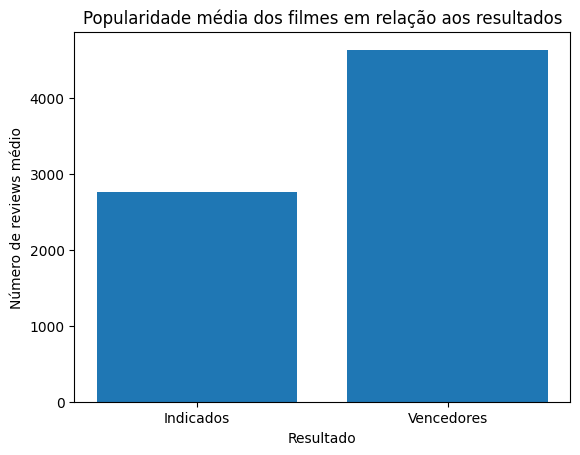

In [351]:
plt.bar(x = ['Indicados', 'Vencedores'], height = [comparacao.mean()['vote_count_nao_vencedor'], comparacao.mean()['vote_count_vencedor']])
plt.xlabel('Resultado')
plt.ylabel('Número de reviews médio')
plt.title('Popularidade média dos filmes em relação aos resultados')
plt.show()

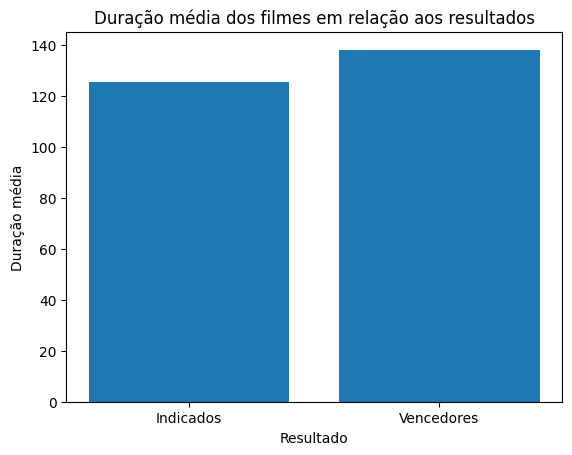

In [352]:
plt.bar(x = ['Indicados', 'Vencedores'], height = [comparacao.mean()['runtime_nao_vencedor'], comparacao.mean()['runtime_vencedor']])
plt.xlabel('Resultado')
plt.ylabel('Duração média')
plt.title('Duração média dos filmes em relação aos resultados')
plt.show()

<Figure size 800x400 with 0 Axes>

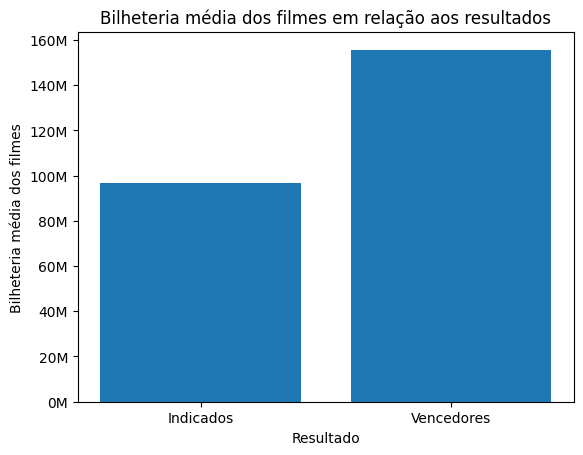

In [353]:
plt.figure(figsize = [8,4])
fig, ax = plt.subplots()
ax.bar(x=['Indicados', 'Vencedores'], height = [comparacao.mean()['revenue_nao_vencedor'], comparacao.mean()['revenue_vencedor']])

def format_million(x, _):
    return f'{x * 1e-6:.0f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_million))
plt.xlabel('Resultado')
plt.ylabel('Bilheteria média dos filmes')
plt.title('Bilheteria média dos filmes em relação aos resultados')
plt.show()

<Figure size 800x400 with 0 Axes>

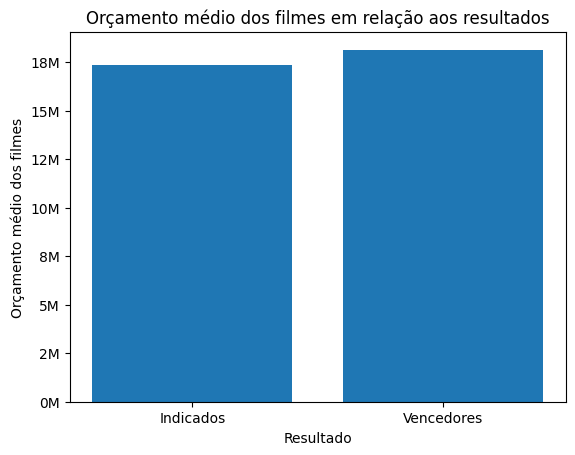

In [354]:
plt.figure(figsize = [8,4])
fig, ax = plt.subplots()
ax.bar(x=['Indicados', 'Vencedores'], height = [comparacao.mean()['budget_nao_vencedor'], comparacao.mean()['budget_vencedor']])

def format_million(x, _):
    return f'{x * 1e-6:.0f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_million))
plt.xlabel('Resultado')
plt.ylabel('Orçamento médio dos filmes')
plt.title('Orçamento médio dos filmes em relação aos resultados')
plt.show()

In [355]:
numeric_variables['proportional'] = df['proportional']
medias = numeric_variables.groupby('year_ceremony').mean().drop(columns = 'winner').reset_index()

medias

,year_ceremony,main_nominations,nominations,wins,nomination_gg,winner_gg,imdb_rating,imdb_popularity,vote_average,vote_count,revenue,runtime,budget,popularity,release_month,profit,proportional
0,1928,1.000,2.666667,1.333333,0.000000,0.000000,7.233333,6945.333333,6.983000,119.333333,1.200000e+06,111.666667,6.667063e+05,6.772667,9.333333,-1.334127e+05,-1.100000
1,1929,1.600,3.000000,0.400000,0.000000,0.000000,5.800000,2578.200000,5.517600,35.800000,8.716000e+05,94.200000,7.580000e+04,3.814000,8.000000,7.200000e+05,9.498681
2,1930,2.200,4.000000,1.000000,0.000000,0.000000,7.000000,15847.000000,6.563600,163.200000,6.540000e+05,100.400000,3.579110e+05,6.246200,5.200000,-6.182200e+04,-0.871530
3,1931,1.800,3.200000,0.600000,0.000000,0.000000,6.140000,2631.000000,5.933400,37.400000,1.116600e+06,106.600000,5.466000e+05,3.855800,2.800000,2.340000e+04,0.097939
4,1932,0.875,2.250000,0.625000,0.000000,0.000000,6.975000,6156.750000,6.742625,82.625000,7.645000e+05,92.000000,1.832500e+05,5.491000,7.250000,3.980000e+05,3.462927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020,3.000,7.666667,1.666667,0.555556,0.222222,8.022222,682175.666667,7.936111,10840.444444,2.920874e+08,142.000000,6.555144e+07,41.953333,9.666667,1.609845e+08,5.093431
92,2021,3.000,6.375000,1.500000,0.625000,0.125000,7.500000,154720.000000,7.476125,2183.375000,8.716347e+06,117.750000,1.237500e+07,21.264125,7.500000,-1.603365e+07,inf
93,2022,2.700,6.000000,1.300000,0.800000,0.200000,7.340000,261774.100000,7.295600,3109.600000,6.498987e+07,139.600000,5.110000e+07,28.687400,10.400000,-3.721013e+07,inf
94,2023,2.700,6.500000,1.300000,0.800000,0.200000,7.540000,302991.200000,7.550000,3527.300000,4.393220e+08,144.300000,8.706000e+07,68.215000,8.700000,2.652020e+08,inf


<Figure size 800x400 with 0 Axes>

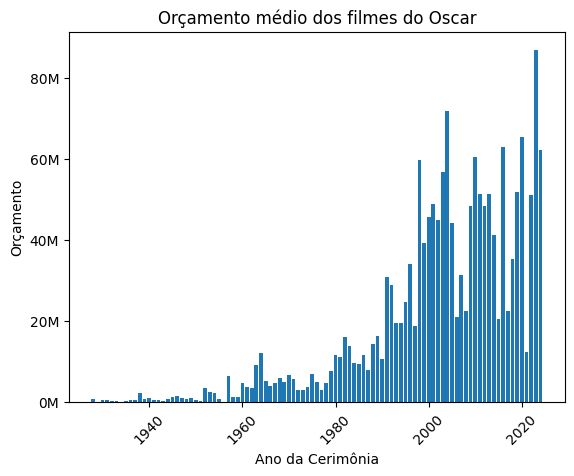

In [356]:
plt.figure(figsize = [8,4])
fig, ax = plt.subplots()
ax.bar(x=medias['year_ceremony'], height=medias['budget'])

def format_million(x, _):
    return f'{x * 1e-6:.0f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_million))

plt.title('Orçamento médio dos filmes do Oscar')
plt.ylabel('Orçamento')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x400 with 0 Axes>

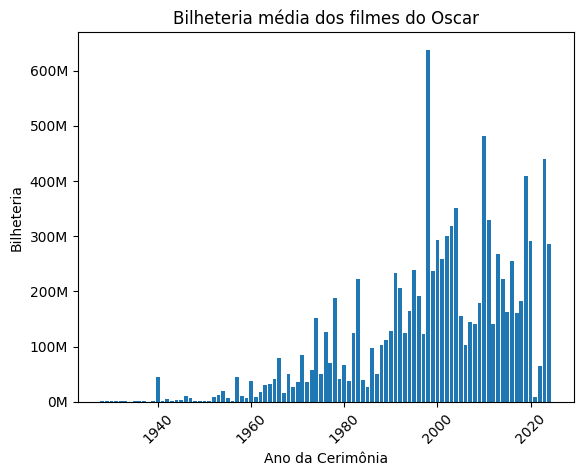

In [357]:
plt.figure(figsize = [8,4])
fig, ax = plt.subplots()
ax.bar(x=medias['year_ceremony'], height=medias['revenue'])

def format_million(x, _):
    return f'{x * 1e-6:.0f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_million))

plt.title('Bilheteria média dos filmes do Oscar')
plt.ylabel('Bilheteria')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x400 with 0 Axes>

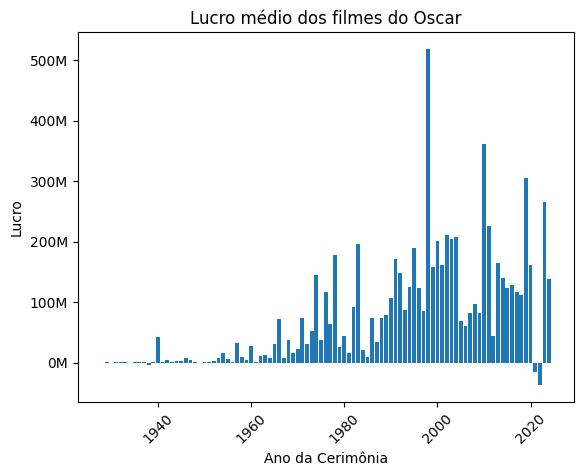

In [358]:
plt.figure(figsize = [8,4])

fig, ax = plt.subplots()
ax.bar(x=medias['year_ceremony'], height=medias['profit'])

def format_million(x, _):
    return f'{x * 1e-6:.0f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_million))

plt.title('Lucro médio dos filmes do Oscar')
plt.ylabel('Lucro')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

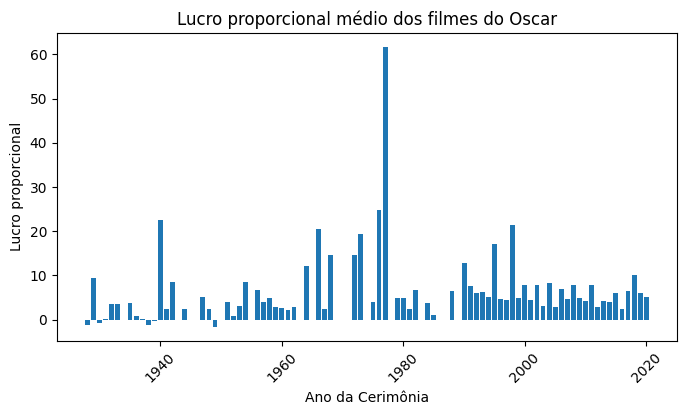

In [359]:
plt.figure(figsize = [8,4])
plt.bar(x=medias['year_ceremony'], height=medias['proportional'])

plt.title('Lucro proporcional médio dos filmes do Oscar')
plt.ylabel('Lucro proporcional')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

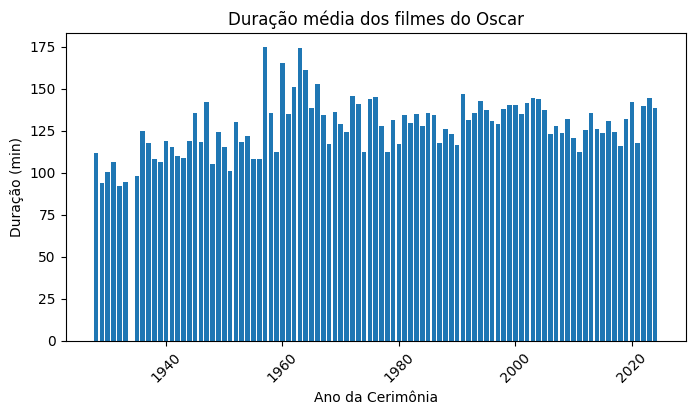

In [360]:
plt.figure(figsize = [8,4])

plt.bar(x=medias['year_ceremony'], height=medias['runtime'])

plt.title('Duração média dos filmes do Oscar')
plt.ylabel('Duração (min)')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

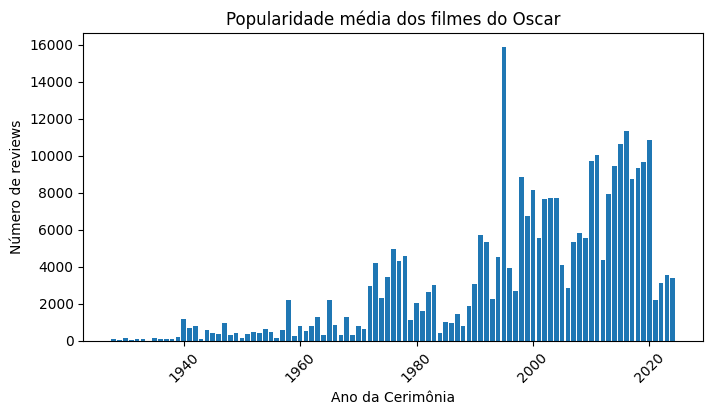

In [361]:
plt.figure(figsize = [8,4])

plt.bar(x=medias['year_ceremony'], height=medias['vote_count'])

plt.title('Popularidade média dos filmes do Oscar')
plt.ylabel('Número de reviews')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

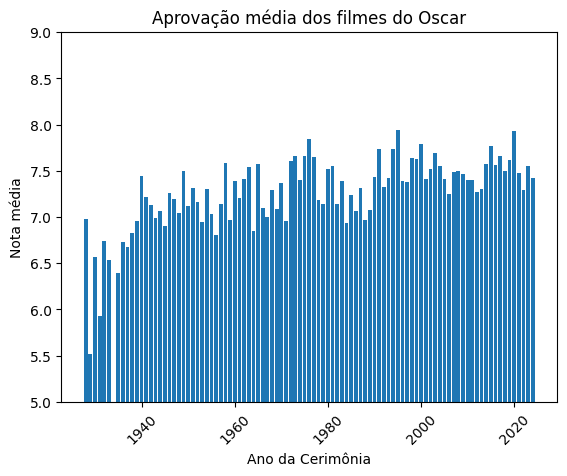

In [362]:
fig, ax = plt.subplots()
ax.bar(x=medias['year_ceremony'], height=medias['vote_average'])
ax.set_ylim(5, 9)

plt.title('Aprovação média dos filmes do Oscar')
plt.ylabel('Nota média')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

### Ganhadores

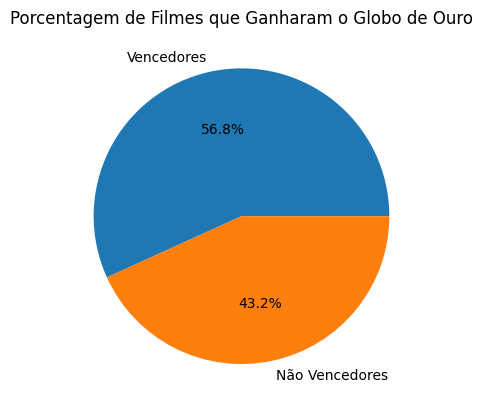

In [363]:
win_gg = winners[winners['year_ceremony'] >= 1944]

v = (win_gg['winner_gg'] == True).sum()
nv = (win_gg['winner_gg'] == False).sum()

plt.pie([v,nv], labels=['Vencedores', 'Não Vencedores'], autopct='%1.1f%%')
plt.title('Porcentagem de Filmes que Ganharam o Globo de Ouro')
plt.show()

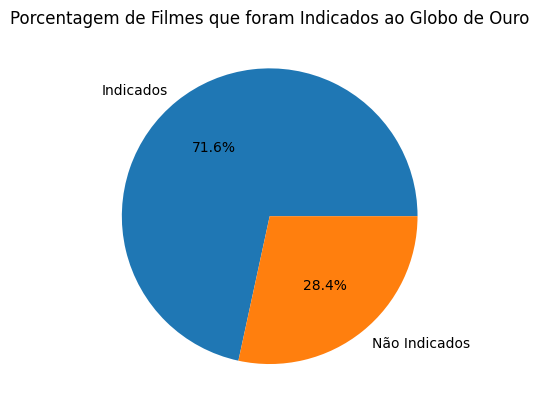

In [364]:
i = (win_gg['nomination_gg'] == True).sum()
ni = (win_gg['nomination_gg'] == False).sum()

plt.pie([i,ni], labels=['Indicados', 'Não Indicados'], autopct='%1.1f%%')
plt.title('Porcentagem de Filmes que foram Indicados ao Globo de Ouro')
plt.show()

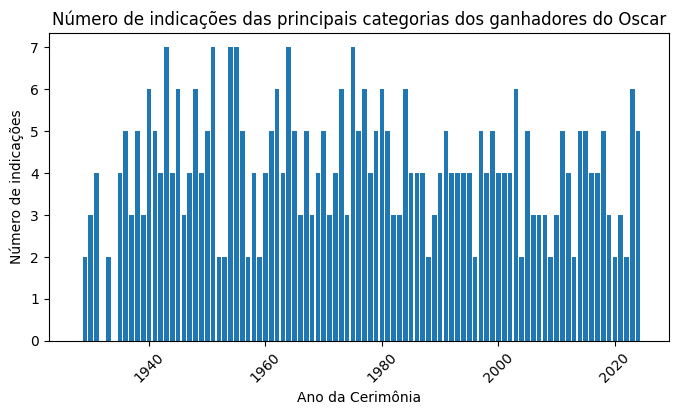

In [365]:
plt.figure(figsize = [8,4])
plt.bar(x=winners['year_ceremony'], height=winners['main_nominations'])

plt.title('Número de indicações das principais categorias dos ganhadores do Oscar')
plt.ylabel('Número de indicações')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

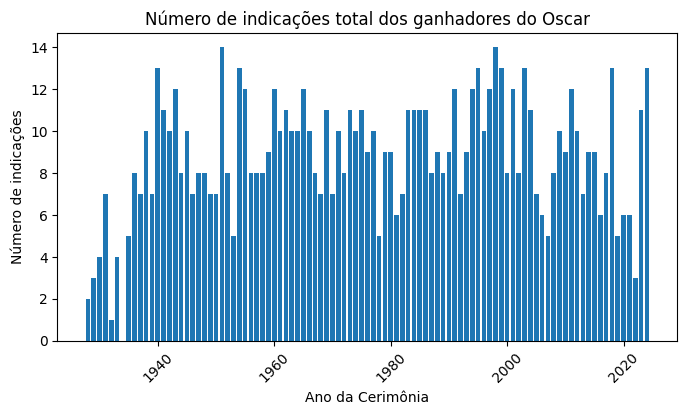

In [366]:
plt.figure(figsize = [8,4])
plt.bar(x=winners['year_ceremony'], height=winners['nominations'])

plt.title('Número de indicações total dos ganhadores do Oscar')
plt.ylabel('Número de indicações')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

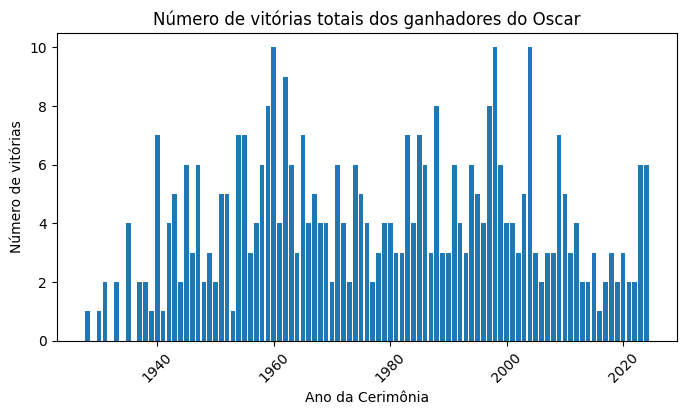

In [367]:
plt.figure(figsize = [8,4])
plt.bar(x=winners['year_ceremony'], height=winners['wins'])

plt.title('Número de vitórias totais dos ganhadores do Oscar')
plt.ylabel('Número de vitórias')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x400 with 0 Axes>

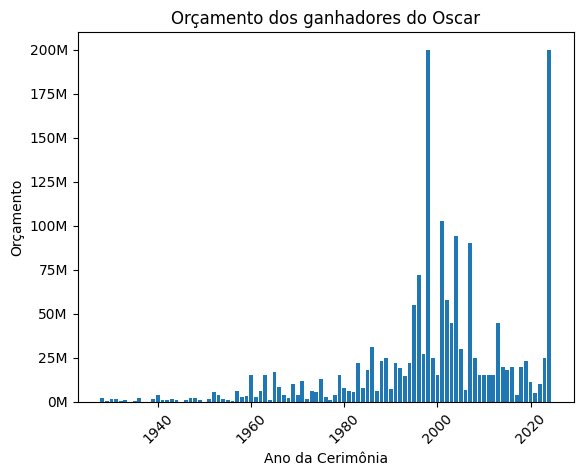

In [368]:
plt.figure(figsize = [8,4])
fig, ax = plt.subplots()
ax.bar(x=winners['year_ceremony'], height=winners['budget'])

def format_million(x, _):
    return f'{x * 1e-6:.0f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_million))

plt.title('Orçamento dos ganhadores do Oscar')
plt.ylabel('Orçamento')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x400 with 0 Axes>

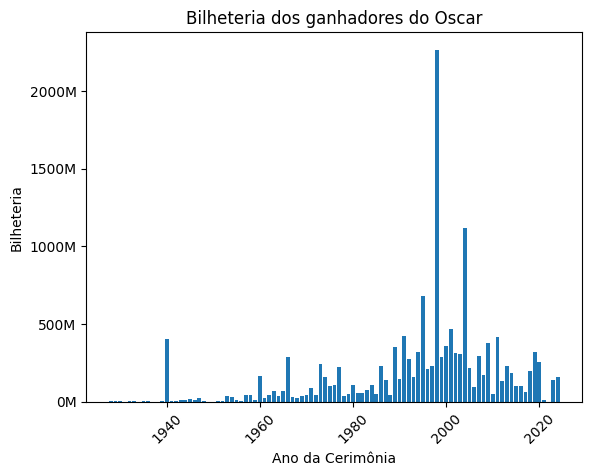

In [369]:
plt.figure(figsize = [8,4])
fig, ax = plt.subplots()
ax.bar(x=winners['year_ceremony'], height=winners['revenue'])

def format_million(x, _):
    return f'{x * 1e-6:.0f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_million))

plt.title('Bilheteria dos ganhadores do Oscar')
plt.ylabel('Bilheteria')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x400 with 0 Axes>

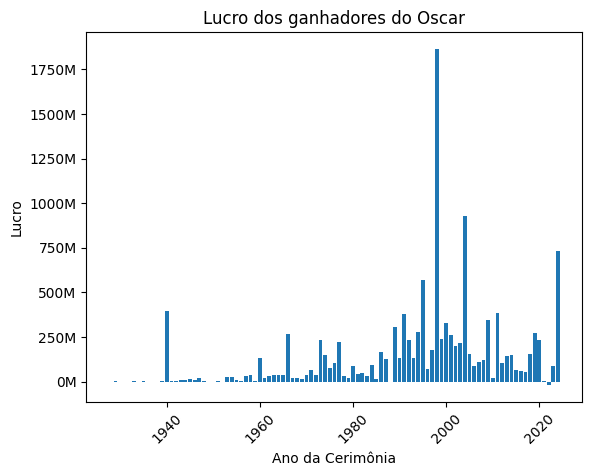

In [370]:
plt.figure(figsize = [8,4])

fig, ax = plt.subplots()
ax.bar(x=winners['year_ceremony'], height=winners['profit'])

def format_million(x, _):
    return f'{x * 1e-6:.0f}M'

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_million))

plt.title('Lucro dos ganhadores do Oscar')
plt.ylabel('Lucro')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

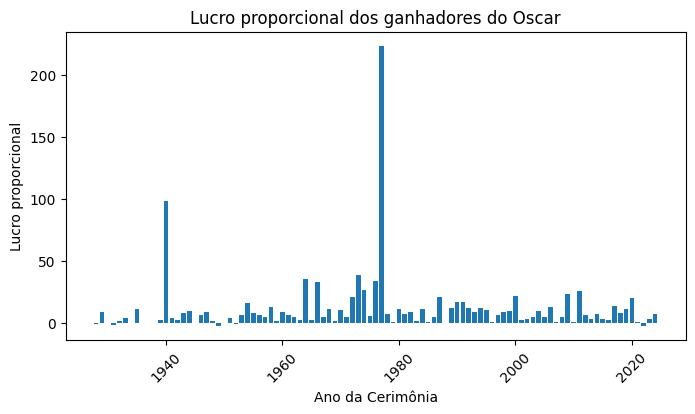

In [371]:
plt.figure(figsize = [8,4])
plt.bar(x=winners['year_ceremony'], height=winners['proportional'])

plt.title('Lucro proporcional dos ganhadores do Oscar')
plt.ylabel('Lucro proporcional')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

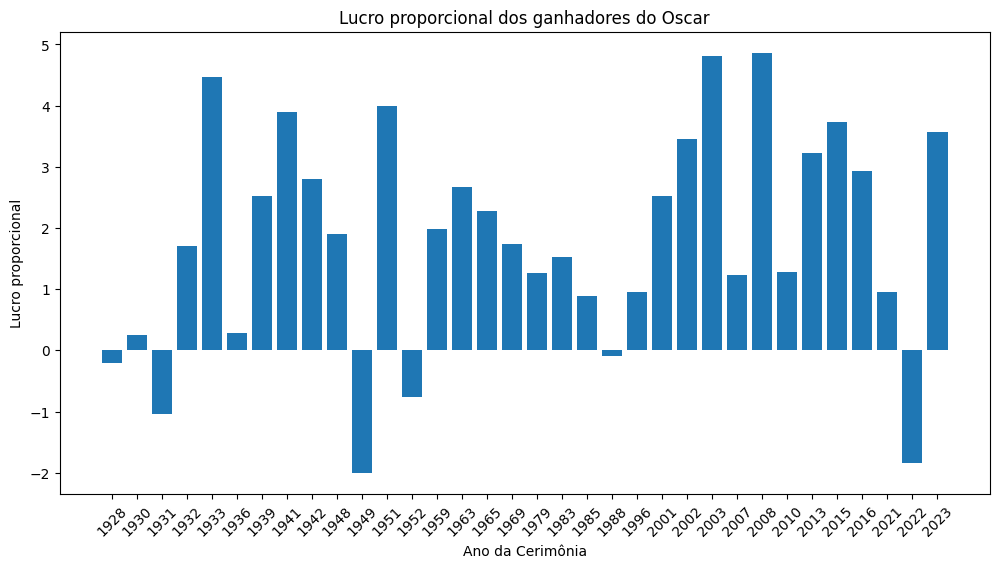

In [372]:
menores_lucros = winners[winners['proportional'] < 5]
plt.figure(figsize = [12,6])

plt.bar(x=[str(ano) for ano in menores_lucros['year_ceremony']], height=menores_lucros['proportional'])

plt.title('Lucro proporcional dos ganhadores do Oscar')
plt.ylabel('Lucro proporcional')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

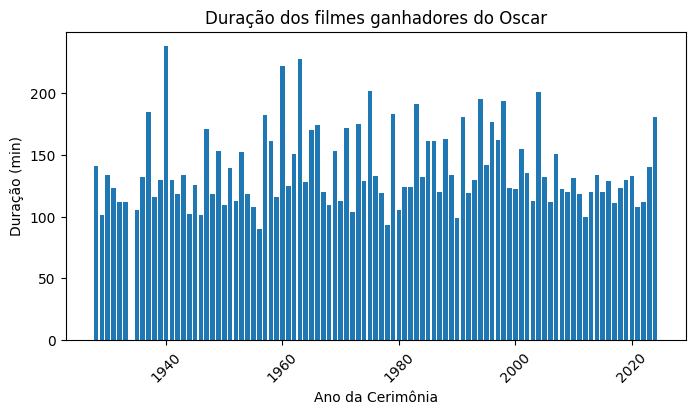

In [373]:
plt.figure(figsize = [8,4])

plt.bar(x=winners['year_ceremony'], height=winners['runtime'])

plt.title('Duração dos filmes ganhadores do Oscar')
plt.ylabel('Duração (min)')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

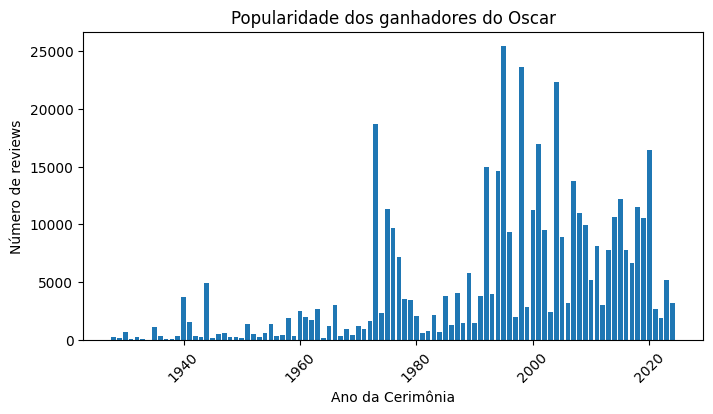

In [374]:
plt.figure(figsize = [8,4])

plt.bar(x=winners['year_ceremony'], height=winners['vote_count'])

plt.title('Popularidade dos ganhadores do Oscar')
plt.ylabel('Número de reviews')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

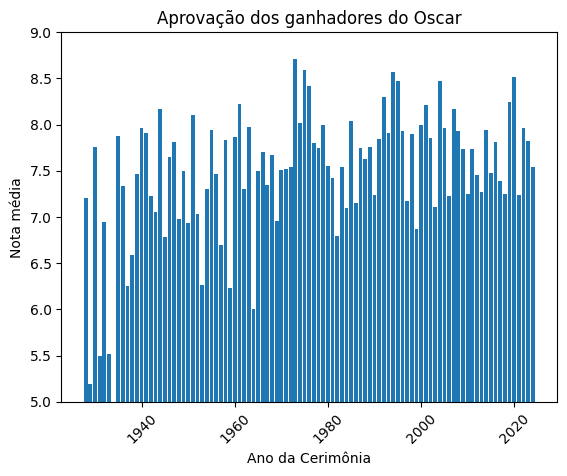

In [375]:
fig, ax = plt.subplots()
ax.bar(x=winners['year_ceremony'], height=winners['vote_average'])
ax.set_ylim(5, 9)

plt.title('Aprovação dos ganhadores do Oscar')
plt.ylabel('Nota média')
plt.xlabel('Ano da Cerimônia')
plt.xticks(rotation=45)
plt.show()

##Modelagem

In [376]:
tst = df.drop(columns = ['original_language', 'popularity', 'genres', 'keywords', 'proportional', 'wins', 'vote_count', 'vote_average', 'nomination_gg'])

In [377]:
X = tst.drop(['film', 'winner', 'year_ceremony'], axis=1)
y = tst['winner']

In [378]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [211]:
anos = np.arange(1928, 2025)

anos_aleatorios = np.random.choice(anos, size=19, replace=False)

In [379]:
train = tst[~tst['year_ceremony'].isin(anos_aleatorios)]
test = tst[tst['year_ceremony'].isin(anos_aleatorios)]

X_train = train.drop(['film', 'winner', 'year_ceremony'], axis=1)
y_train = train['winner']
X_test = test.drop(['film', 'winner', 'year_ceremony'], axis=1)
y_test = test['winner']

In [380]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [381]:
best_params = grid_search_rf.best_params_
print(best_params)

best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [382]:
y_pred = best_rf.predict_proba(X_test)[:,1]

In [383]:
results = pd.DataFrame({
    'Ano': test['year_ceremony'],
    'Filme': test['film'],
    'Probabilidade': y_pred,
    'Venceu': test['winner']
})

idx_max_prob = results.groupby('Ano')['Probabilidade'].idxmax()

resultados_filtrados = results.loc[idx_max_prob]
results['Predição'] = results.index.isin(idx_max_prob)

idx_top2_prob = results.groupby('Ano')['Probabilidade'].apply(lambda x: x.nlargest(2).index)

idx_top2_prob = set(idx_top2_prob.explode())

results['Top 2'] = results.index.isin(idx_top2_prob)

resultados_reais = results[results['Venceu'] == True].drop(columns = 'Venceu')

fil = resultados_filtrados.index
real = resultados_reais.index

resultados_filtrados = resultados_filtrados.reset_index()
resultados_reais = resultados_reais.reset_index()

resultados_filtrados['index vencedor'] = real
resultados_filtrados['Filme vencedor'] = resultados_reais['Filme']
resultados_filtrados['Prob vencedor'] = resultados_reais['Probabilidade']

resultados_filtrados.set_index(fil)

resultados_filtrados

,index,Ano,Filme,Probabilidade,Venceu,index vencedor,Filme vencedor,Prob vencedor
0,4,1929,the broadway melody,0.122613,True,4,the broadway melody,0.122613
1,11,1930,all quiet on the western front,0.098995,True,11,all quiet on the western front,0.098995
2,103,1941,rebecca,0.370889,True,103,rebecca,0.370889
3,157,1948,gentleman's agreement,0.335624,True,157,gentleman's agreement,0.335624
4,164,1949,the treasure of the sierra madre,0.293336,False,160,hamlet,0.047133
5,176,1952,a streetcar named desire,0.255166,False,177,an american in paris,0.193465
6,187,1954,from here to eternity,0.372099,True,187,from here to eternity,0.372099
7,195,1956,marty,0.131035,True,195,marty,0.131035
8,203,1957,around the world in eighty days,0.335536,True,203,around the world in eighty days,0.335536
9,207,1958,the bridge on the river kwai,0.284653,True,207,the bridge on the river kwai,0.284653


In [384]:
results[results['Ano'] == 1983].sort_values(by='Probabilidade', ascending=False)

,Ano,Filme,Probabilidade,Venceu,Predição,Top 2
334,1983,tootsie,0.437769,False,True,True
330,1983,gandhi,0.355734,True,False,True
331,1983,e.t. the extra-terrestrial,0.138670,False,False,False
333,1983,missing,0.110097,False,False,False
332,1983,the verdict,0.092143,False,False,False


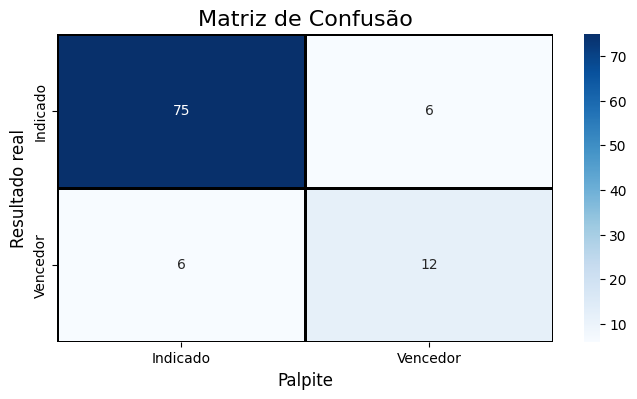

In [385]:
cm = confusion_matrix(results['Venceu'], results['Predição'])
labels = ['Indicado', 'Vencedor']
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize=(8, 4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=1, linecolor='black')

plt.title('Matriz de Confusão', fontsize=16)
plt.xlabel('Palpite', fontsize=12)
plt.ylabel('Resultado real', fontsize=12)

plt.show()

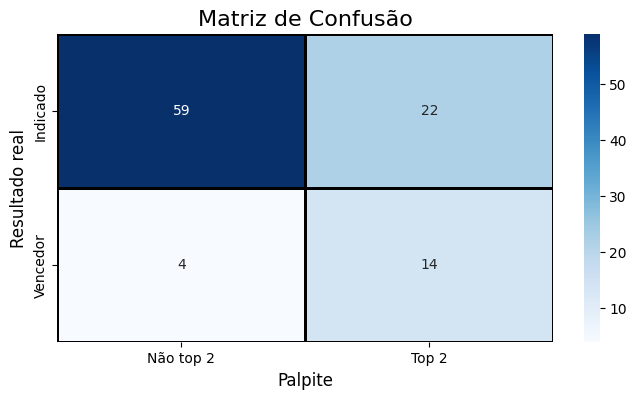

In [386]:
cm2 = confusion_matrix(results['Venceu'], results['Top 2'])
labels2 = ['Não top 2', 'Top 2']
df_cm2 = pd.DataFrame(cm2, index = labels, columns = labels2)

plt.figure(figsize=(8, 4))
sns.heatmap(df_cm2, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=1, linecolor='black')

plt.title('Matriz de Confusão', fontsize=16)
plt.xlabel('Palpite', fontsize=12)
plt.ylabel('Resultado real', fontsize=12)

plt.show()

In [387]:
acuracia_t1 = df_cm['Vencedor']['Vencedor'] / (df_cm['Indicado']['Vencedor'] + df_cm['Vencedor']['Vencedor'])

acuracia_t2 = df_cm2['Top 2']['Vencedor'] / (df_cm2['Não top 2']['Vencedor'] + df_cm2['Top 2']['Vencedor'])

print(f'Acurácia top-1: {round(100*acuracia_t1, 2)}%\nAcurácia top-2: {round(100*acuracia_t2, 2)}%')

Acurácia top-1: 66.67%
Acurácia top-2: 77.78%


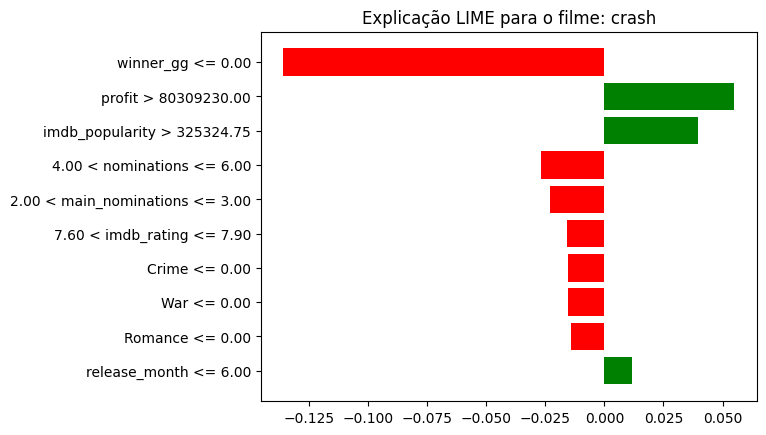

In [388]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['Indicado', 'vencedor'],
    mode='classification'
)

i = 445
exp = explainer.explain_instance(
    data_row=X.iloc[i].values,
    predict_fn=grid_search_rf.predict_proba
)

exp.as_pyplot_figure()
plt.title(f'Explicação LIME para o filme: {tst.iloc[i]["film"]}')
plt.show()

##Previsão Oscar 2025

In [389]:
num = X.columns[:10]
gen = X.columns[10:]

num

Index(['main_nominations', 'nominations', 'winner_gg', 'imdb_rating',
       'imdb_popularity', 'revenue', 'runtime', 'budget', 'release_month',
       'profit'],
      dtype='object')

In [390]:
def novo_ano():
  df = {}
  for i in range(10):
    nome = input(f'Filme {i+1}: ')
    film = []

    for j in num:
      film.append(input(f'{j} de {nome}: '))

    k = 0
    cont = 1
    genres = []
    print(f'Gêneros: {gen}')
    while k != '':
      genres.append(k)
      k = input(f'Gênero {cont} de {nome}: ')
      cont += 1
    genres.pop(0)

    for l in gen:
      if l in genres:
        film.append(1)
      else:
        film.append(0)

    df[nome] = film

  return(df)

In [393]:
criacao = novo_ano()

Filme 1: Emilia Pérez
main_nominations de Emilia Pérez: 4
nominations de Emilia Pérez: 13
winner_gg de Emilia Pérez: 1
imdb_rating de Emilia Pérez: 5.5
imdb_popularity de Emilia Pérez: 72000
revenue de Emilia Pérez: 15000000
runtime de Emilia Pérez: 132
budget de Emilia Pérez: 22000000
release_month de Emilia Pérez: 11
profit de Emilia Pérez: 0
Gêneros: Index(['Western', 'Crime', 'Fantasy', 'Comedy', 'Horror', 'Music', 'War',
       'Mystery', 'Drama', 'Romance', 'Action', 'History', 'Thriller',
       'Animation', 'Family', 'Science Fiction', 'Adventure'],
      dtype='object')
Gênero 1 de Emilia Pérez: Comedy
Gênero 2 de Emilia Pérez: Crime
Gênero 3 de Emilia Pérez: Drama
Gênero 4 de Emilia Pérez: Music
Gênero 5 de Emilia Pérez: Thriller
Gênero 6 de Emilia Pérez: 
Filme 2: Anora
main_nominations de Anora: 4
nominations de Anora: 6
winner_gg de Anora: 0
imdb_rating de Anora: 7.7
imdb_popularity de Anora: 98000
revenue de Anora: 32000000
runtime de Anora: 139
budget de Anora: 6000000
r

In [403]:
df_dmvc = pd.DataFrame(criacao).transpose()

df_dmvc.columns = X.columns

df_dmvc['revenue'] = df_dmvc['revenue'].astype(int)
df_dmvc['budget'] = df_dmvc['budget'].astype(int)

df_dmvc['profit'] = df_dmvc['revenue'] - 2*df_dmvc['budget']

df_dmvc = df_dmvc.astype({col: 'int' for col in df_dmvc.columns if col != 'imdb_rating'})

df_dmvc['winner_gg'] = df_dmvc['winner_gg'].astype(bool)
df_dmvc['imdb_rating'] = df_dmvc['imdb_rating'].astype(float)

df_dmvc

,main_nominations,nominations,winner_gg,imdb_rating,imdb_popularity,revenue,runtime,budget,release_month,profit,...,Mystery,Drama,Romance,Action,History,Thriller,Animation,Family,Science Fiction,Adventure
Emilia Pérez,4,13,True,5.5,72000,15000000,132,22000000,11,-29000000,...,0,1,0,0,0,1,0,0,0,0
Anora,4,6,False,7.7,98000,32000000,139,6000000,10,20000000,...,0,1,1,0,0,0,0,0,0,0
The Brutalist,5,10,True,7.9,30000,32000000,215,9600000,12,12800000,...,0,1,0,0,0,0,0,0,0,0
Conclave,3,8,False,7.4,100000,96000000,120,20000000,10,56000000,...,1,1,0,0,0,1,0,0,0,0
A Complete Unknown,5,8,False,7.6,32000,105000000,141,65000000,12,-25000000,...,0,1,0,0,0,0,0,0,0,0
Ainda Estou Aqui,1,3,False,8.8,75000,26000000,137,1500000,1,23000000,...,0,1,0,0,1,0,0,0,0,0
Nickel Boys,1,2,False,7.2,7000,2600000,140,23200000,12,-43800000,...,0,1,0,0,0,0,0,0,0,0
The Substance,3,5,False,7.3,251000,77000000,141,17500000,9,42000000,...,0,1,0,0,0,0,0,0,1,0
Wicked,2,10,False,7.6,129000,728000000,160,145000000,11,438000000,...,0,0,1,0,0,0,0,0,0,0
Dune: Part Two,0,5,False,8.5,600000,715000000,166,190000000,2,335000000,...,0,1,0,1,0,0,0,0,1,1


In [404]:
y_pred = best_rf.predict_proba(df_dmvc)[:,1]

In [405]:
y = sum(y_pred)

for i in range(len(y_pred)):
    y_pred[i] = y_pred[i]/y

In [406]:
resultado = pd.DataFrame({
    'Filme': df_dmvc.index,
    'Probabilidade': y_pred
})

resultado = resultado.sort_values(by='Probabilidade', ascending=False).reset_index(drop = True)

resultado['Probabilidade'] = [f'{round(100*y, 2)}%' for y in resultado['Probabilidade']]

resultado.index = resultado.index + 1

resultado

,Filme,Probabilidade
1,The Brutalist,28.97%
2,Emilia Pérez,15.93%
3,Ainda Estou Aqui,10.77%
4,Dune: Part Two,9.59%
5,Wicked,9.24%
6,A Complete Unknown,7.92%
7,Anora,6.68%
8,Conclave,4.76%
9,The Substance,3.75%
10,Nickel Boys,2.4%


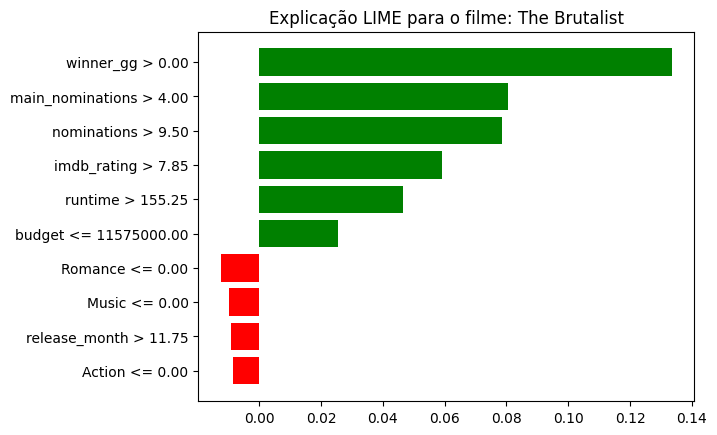

In [407]:
films = df_dmvc.index

explainer = LimeTabularExplainer(
    training_data=df_dmvc.values,
    feature_names=df_dmvc.columns,
    class_names=['Indicado', 'vencedor'],
    mode='classification'
)

i = 2
exp = explainer.explain_instance(
    data_row=df_dmvc.iloc[i].values,
    predict_fn=grid_search_rf.predict_proba
)

exp.as_pyplot_figure()
plt.title(f'Explicação LIME para o filme: {films[i]}')
plt.show()

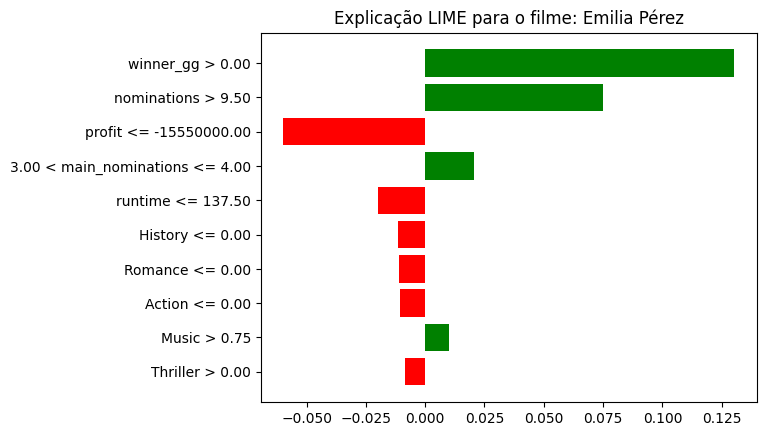

In [408]:
i = 0
exp = explainer.explain_instance(
    data_row=df_dmvc.iloc[i].values,
    predict_fn=grid_search_rf.predict_proba
)

exp.as_pyplot_figure()
plt.title(f'Explicação LIME para o filme: {films[i]}')
plt.show()

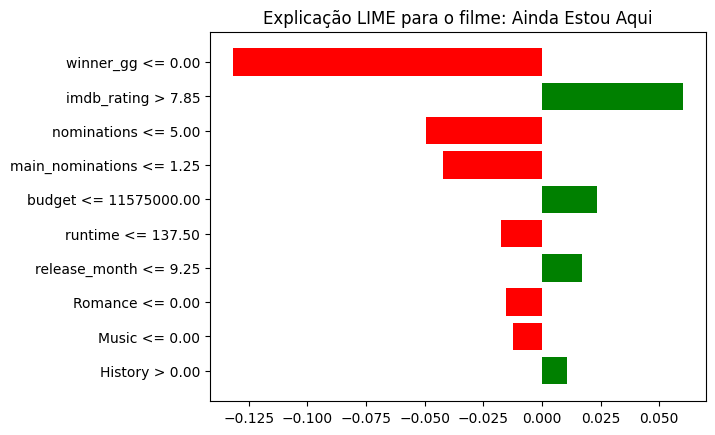

In [409]:
i = 5
exp = explainer.explain_instance(
    data_row=df_dmvc.iloc[i].values,
    predict_fn=grid_search_rf.predict_proba
)

exp.as_pyplot_figure()
plt.title(f'Explicação LIME para o filme: {films[i]}')
plt.show()